In [2]:
%matplotlib inline

In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import models
from itertools import combinations

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

## Introduction

Our goal is to explore the cars data set and build a model that will accurately predict a car's fuel consumption, using all assumptions appropriate for this kind of analysis.

# Table of Contents <a class="anchor" id="contents"></a>
* 1.1 [ETL](#ETL)  
* 1.2 [EDA](#EDA)  
    * 1.2.1 [MPG](#mpg)
    * 1.2.2 [Cylinders](#cyl)
    * 1.2.3 [Displacement](#disp)
    * 1.2.4 [Horsepower](#hp)
    * 1.2.5 [Weight](#wt)
    * 1.2.6 [Acceleration](#acc)
    * 1.2.7 [Year](#year)
    * 1.2.8 [Origin](#origin)
    * 1.2.9 [MPG vs Cylinders](#vscyl)
    * 1.2.10 [MPG vs Displacement](#vsdisp)
    * 1.2.11 [MPG vs Horsepower](#vshp)
    * 1.2.12 [MPG vs Weight](#vswt)
    * 1.2.13 [MPG vs Acceleration](#vsacc)
    * 1.2.14 [MPG vs Year](#vsyear)
    * 1.2.15 [MPG vs Origin](#vsorigin)
    * 1.2.16 [More EDA](#meda)
* 1.3 [Build The Model](#modeling)
* 1.4 [Describe The Model](#describe)
* 1.5 [Use the Model](#use)

## 1.1 - ETL <a class="anchor" id="ETL"></a>
[Contents](#contents)

Lets consult the data dictionary of the cars data set.

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

We have 5 continuous variables, 2 discrete numeric variables and 1 categorical variable (origin). The car name variable is unique to each element in the data set. We can use car name as the row indices ( not necessary but we can try it out). The data file link provided doesn't have column headers so we'll define them as we import the data using pandas.

In [3]:
header = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "origin", "name"]
data = pd.read_csv(auto_mpg_data, delim_whitespace = True, names = header, index_col = "name")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1


We are now ready to perform Exploratory Data Analysis (EDA).

## 1.2 - EDA <a class="anchor" id="EDA"></a>
[Contents](#contents)

Beginning the exploratory data analysis step of this problem set, lets quickly look at the variables see if they match the data dictionary that we were provided with.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398 entries, chevrolet chevelle malibu to chevy s-10
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   year          398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 28.0+ KB


We have a total of 398 different cars in our data set. As expected we have 4 continuous floating point variables. Horsepower however has an object type. We'll find out more in our EDA for horsepower, but i suspect this might be because we have missing values. The other variables are of types that make sense. The origin categorical variable is an integer is a categorical variable that represents different countries, and the remaining variables are all discrete numeric variables.

Before continuing, several helper functions will be useful to define.

In [4]:
#Boxplot function
def boxplot(data, var):
    figure = plt.figure(figsize = (5,6))

    axes = figure.add_subplot(1,1,1)
    axes.set_title("Distribution of " + var)
    axes.set_ylabel(var)
    plt.boxplot(data[var])

    plt.xticks([1], [''])
    plt.show()

#Utility Function to print a bar chart
def barplot(data, var, percent = False, count = False):
    figure = plt.figure(figsize=(10,6))
    
    if (percent == False):
        xs = np.unique(data[var])
        ys = data[var].value_counts().sort_index()
        label = "Count"
    else:
        xs = np.unique(data[var])
        ys = data[var].value_counts().sort_index()/len(data[var])
        label = "Percent"

    axes = figure.add_subplot(1,1,1)
    axes.bar(xs, ys, color = "dimgray")
    axes.set_ylabel(label)
    axes.set_xlabel(var)
    axes.set_title(label + " of "+ var)

    plt.show()
    plt.close()

#Utility Function to print a histogram
def histplot(data, var, bins = 10, density = False):
    figure = plt.figure(figsize=(10,6))
    
    if (density == True):
        title = "Density"
    else:
        title = "Count"
    
    
    axes = figure.add_subplot(1,1,1)
    axes.hist(data[var], bins = bins, color = "dimgray", density = density)
    axes.set_ylabel(title)
    axes.set_title(title + " of " + var)
    axes.set_xlabel(var)

    plt.show()
    plt.close()
    
#Utility Function taken from previous lab 5 to compare numerical variables by category.
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)
        
#Utility Function to plot a scatterplot of two numerical variables. This was taken from module 5 example.
def scatter(data, x, y, jitter=0.0, skip_lowess=True, skip_reg = True):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    ys = data[y]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
        ys = data[y] + stats.norm.rvs( 0, 0.5, data[y].size)

    axes.scatter(xs, ys, marker="o", color="DimGray", alpha=0.5)
    
    if not skip_reg:
        axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {1} v. {0}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

#Utility Function to print out correlation statistics of input data.
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r   =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])
    
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, zorder=1)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

### 1.2.1 - MPG <a class="anchor" id="mpg"></a>
[Contents](#contents)

The target variable MPG is what we're interested in modeling. What factors influence a car's fuel efficiency is a topic of great interest to many people and seeing if we can predict mpg based on certain factors could be a useful thing to be able to do. Lets start with a quick snapshot of the MPG target variable.

In [6]:
data["mpg"].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The MPG target variable has a mean value of 23.5 in the data set, with a standard deviation of 7.815. The median is 23, indicating not too much skew in the data. Lets visualize using a boxplot:

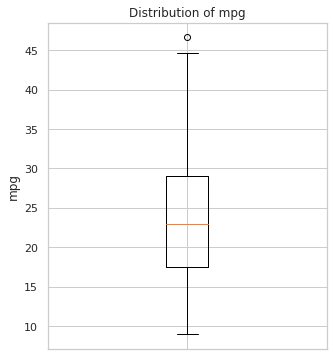

In [7]:
boxplot(data, "mpg")

Nothing out of the ordinary here. A histogram might help show us any slight skew there might be that we cannot see using a boxplot.

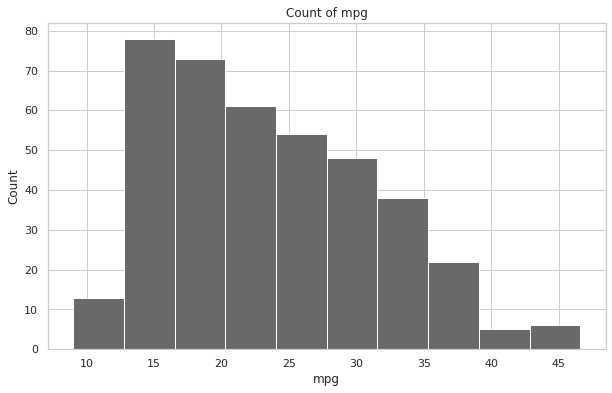

In [8]:
histplot(data, "mpg")

The distribution of MPG here is not easy to identify. The lack of skew assumed prior seems to be present much more here. Most cars seem to have an MPG of 15 to 20. Maybe a different bin setting will help. Lets increase the resolution.

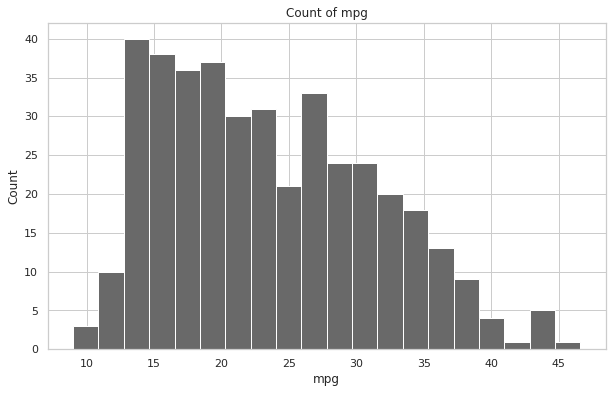

In [9]:
histplot(data, "mpg", bins = 20)

This hasn't really improved what the distribution looks like. However there does seem to be a spike of number of cars at or around 26 mpg compared to 25. That could be an artifact of the binning however.

### 1.2.2 - Cylinders <a class="anchor" id="cyl"></a>
[Contents](#contents)

The cylinders variable corresponds to the engine's design. Engines have different numbers of cyclinders which contain pistons that transform the chemical energy from the fuel into mechanical energy. This in turn generates the power for the car to accelerate. The number of cylinders a car has generally doesn't vary too much. We could treat it as a categorical variable. I expect that the number of cylinders will range between 4 and 12. V12's are definitely rare and I expect most to be around 4-6.

In [10]:
data["cylinders"].head()

name
chevrolet chevelle malibu    8
buick skylark 320            8
plymouth satellite           8
amc rebel sst                8
ford torino                  8
Name: cylinders, dtype: int64

The number of cylinders in a car is definitely a discrete numeric variable. Lets plot it out using a bar chart.

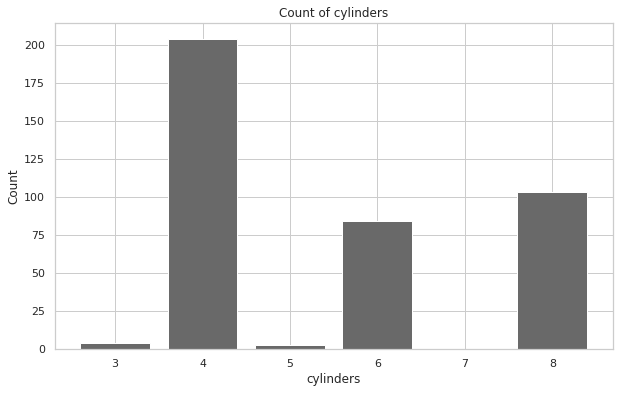

In [11]:
barplot(data, "cylinders")

We have very few 3 cylinder cars, plenty of 4 cylinders, 6, and 8. There are only a few outlier cars with odd numbered cylinders.

### 1.2.3 - Displacement <a class="anchor" id="disp"></a>
[Contents](#contents)

Displacement is a measure of the total volume of the cyclinders. (very brief explanation). It is calculated using the bore of a cylinder, distance a piston travels, and the number of cylinders. It's how much gas volume an engine can hold to push pistons. This seems like a pretty important stat that actually includes a variable we have already looked at independently: cylinders. According to wikipedia, displacement is a determining factor in horsepower and torque. Lets take a look at our distribution of displacement.

In [12]:
data["displacement"].describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

The average displacement is 193.43, with a standard deviation of 104. The minimum displacement is 68, a max displacement of 455 and a median of 148. Given our distribution of cyclinders, and how cylinders affect displacement based on how its calculated, I expect a distribution that follows a smoothed distribution that we saw earlier. Lets plot a histogram:

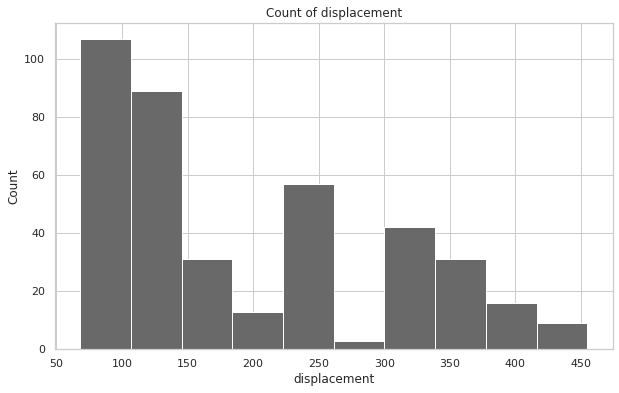

In [13]:
histplot(data, "displacement")

Our hunch seemed to be right. There are what looks like to be 3 peaks. The first is at or around 125, the next is near 250, and the last is above 300. I'd expect that those three peaks correspond to the three cyclinder peaks that we saw earlier.

### 1.2.4 - Horsepower <a class="anchor" id="hp"></a>
[Contents](#contents)

Horsepower is a unit of measurement for power. Power describes a rate of work done. So for example, lifting an object into the air requires some amount of power to do it at a certain speed. A car moving at a certain speed also requires a certain amount of power.

Now that we know that displacement determines horsepower, I'd expect the distribution here to be the same as the previous one (or very similar). Lets take a look:

In [5]:
data["horsepower"].describe()

count       398
unique       94
top       150.0
freq         22
Name: horsepower, dtype: object

The data type here is a bit odd. Usually horsepower is a continuous unit of measure, but this datatype makes it look like its a categorical variable. We also know from looking at the data dictionary that horsepower has missing values. Lets find them:

In [6]:
data["horsepower"] = pd.to_numeric(data["horsepower"], errors = 'coerce')
data[data["horsepower"].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
ford pinto,25.0,4,98.0,NaN,2046.0,19.0,71,1
ford maverick,21.0,6,200.0,NaN,2875.0,17.0,74,1
renault lecar deluxe,40.9,4,85.0,NaN,1835.0,17.3,80,2
ford mustang cobra,23.6,4,140.0,NaN,2905.0,14.3,80,1
renault 18i,34.5,4,100.0,NaN,2320.0,15.8,81,2
amc concord dl,23.0,4,151.0,NaN,3035.0,20.5,82,1


These are the 6 cars with missing horsepower entries. Lets remove them from the data set.

In [7]:
data = data.dropna()
data[data["horsepower"].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,


With the missing entries removed, lets look at the actual variable.

In [8]:
data["horsepower"].describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

Horsepower ranges from 46 to 230 in our data set, with a mean of 104 and a standard deviation of 38.49. For reference, american cars tend to average around 108-200 horsepower according to wikipedia. The median is lower than the average at 93.5 which suggests some skewing. Lets look at a histogram to see if we have our expected pattern:

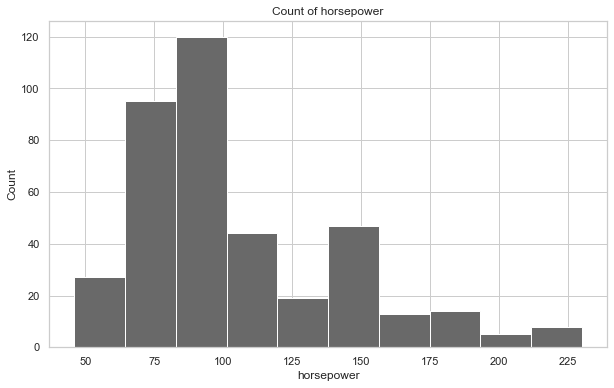

In [9]:
histplot(data, "horsepower")

It's a little harder to see the pattern that we saw with cylinders and displacement. Maybe increasing the bins will help:

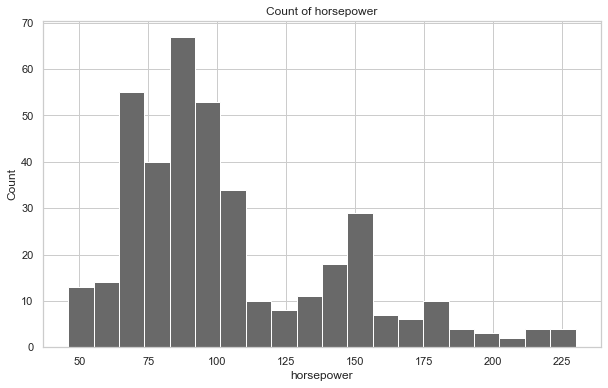

In [10]:
histplot(data, "horsepower", bins = 20)

The 2nd and 3rd peak are certainly less pronounced, however we do still see that 150 peak as well as the 75-100 peak.

### 1.2.5 - Weight <a class="anchor" id="wt"></a>
[Contents](#contents)

The weight of the car should play a major role in the fuel efficiency. The heavier a car is the more power required and therefore the more fuel required to move it. I suspect that this variable will be heavily negatively correlated with MPG. Weight is a continous variable with the following characteristics:

In [11]:
data["weight"].describe()

count     392.000000
mean     2977.584184
std       849.402560
min      1613.000000
25%      2225.250000
50%      2803.500000
75%      3614.750000
max      5140.000000
Name: weight, dtype: float64

The average weight is 2977, with a min of 1613 and a max of 5140. The standard deviation is 849 and the median is 2800. This suggests positive skew.

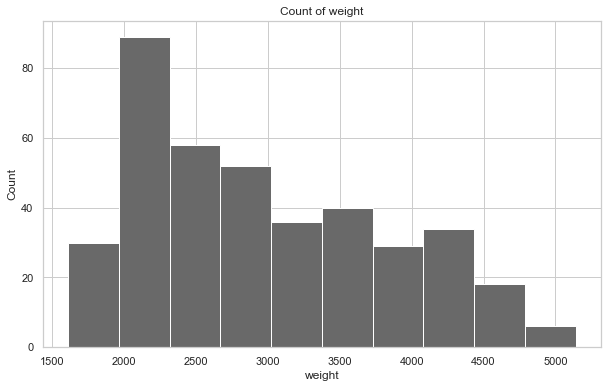

In [12]:
histplot(data, "weight")

Here we don't see as much of a similar distribution as the previous few data variables. It might make sense that a car's weight is correlated with the size of the engine. After all, the heavier a car (or truck?) the more power the engine needed. There's also the caveat that some cars are built lighter to take advantage of a stronger engine for a sportier feel.

### 1.2.6 - Acceleration <a class="anchor" id="acc"></a>
[Contents](#contents)

Acceleration should be heavily correlated with the size of the engine, but negatively correlated with the weight of the car. It will be interesting to see how these two variables interact with each other in our analysis. I suspect that acceleration will closely follow the distributions of horsepower, cyclinders, and displacement. First, some descriptive statistics:

In [13]:
data["acceleration"].describe()

count    392.000000
mean      15.541327
std        2.758864
min        8.000000
25%       13.775000
50%       15.500000
75%       17.025000
max       24.800000
Name: acceleration, dtype: float64

The average acceleration is 15.54, with a standard deviation fo 2.75. The minimum is 8 and the max is 24. The median sits pretty close to the average at 15.5. Maybe the acceleration distribution will not look like I expected. Perhaps the cars in this dataset aren't all sports cars! (larger cars that simply need larger engines).

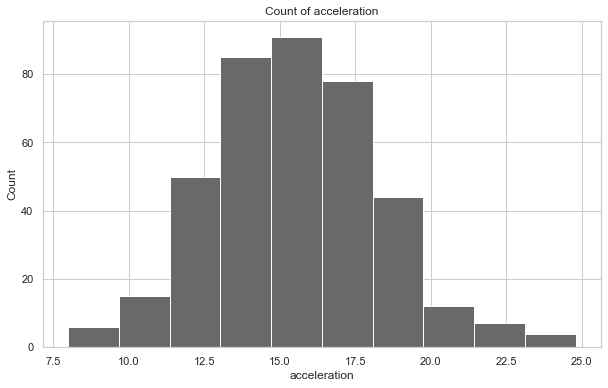

In [14]:
histplot(data, "acceleration")

Acceleration looks like it could be normally distributed. With this we don't know too much about how acceleration might play a role. If anything acceleration could be simply a variable that is determined mostly by the weight of the car, the engine type and size. This means that if we were to use it in our model it might not add much more information to it given that it could be highly correlated with those factors.

### 1.2.7 - Year <a class="anchor" id="year"></a>
[Contents](#contents)

Year is an interesting variable. Intuitively a cars year might suggest how advanced a car is. Newer cars might tend to have better MPG while older cars might have older mechanics or older technologies that leave the car less fuel efficient. Lets take a look at the variable:

In [15]:
data["year"].describe()

count    392.000000
mean      75.979592
std        3.683737
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: year, dtype: float64

The year variable is technically categorical ranging from 1970 to 1982. The average car's year is 1976 which sits right at the median. Lets plot out the years using a barplot.

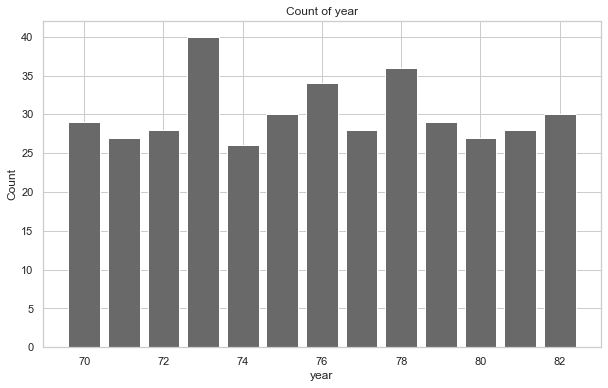

In [16]:
barplot(data, "year")

It looks fairly uniform in its distribution. The year 73 seems to be the most frequent year, but that doesn't really tell us too much. Other than that there isn't much to gain from looking at this variable at this time.

### 1.2.8 - Origin <a class="anchor" id="origin"></a>
[Contents](#contents)

Origin is another categorical variable. The data dictionary does not describe what they are but lets take a look to see if we can figure out what the origins are.

In [17]:
data["origin"].describe()

count    392.000000
mean       1.576531
std        0.805518
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: origin, dtype: float64

There are only 3 categories. 1, 2, and 3. Lets see if we can classify them.

In [18]:
data[data["origin"] == 1]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
chevrolet camaro,27.0,4,151.0,90.0,2950.0,17.3,82,1
ford mustang gl,27.0,4,140.0,86.0,2790.0,15.6,82,1
dodge rampage,32.0,4,135.0,84.0,2295.0,11.6,82,1


It looks like those of category 1 are cars from the United States.

In [19]:
data[data["origin"] == 2]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
volkswagen 1131 deluxe sedan,26.0,4,97.0,46.0,1835.0,20.5,70,2
peugeot 504,25.0,4,110.0,87.0,2672.0,17.5,70,2
audi 100 ls,24.0,4,107.0,90.0,2430.0,14.5,70,2
saab 99e,25.0,4,104.0,95.0,2375.0,17.5,70,2
bmw 2002,26.0,4,121.0,113.0,2234.0,12.5,70,2
...,...,...,...,...,...,...,...,...
volkswagen jetta,33.0,4,105.0,74.0,2190.0,14.2,81,2
peugeot 505s turbo diesel,28.1,4,141.0,80.0,3230.0,20.4,81,2
volvo diesel,30.7,6,145.0,76.0,3160.0,19.6,81,2


Category 2 is European

In [20]:
data[data["origin"] == 3].tail(60)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
honda civic,24.0,4,120.0,97.0,2489.0,15.0,74,3
subaru,26.0,4,108.0,93.0,2391.0,15.5,74,3
toyota corolla,29.0,4,97.0,75.0,2171.0,16.0,75,3
toyota corona,24.0,4,134.0,96.0,2702.0,13.5,75,3
datsun 710,24.0,4,119.0,97.0,2545.0,17.0,75,3
honda civic cvcc,33.0,4,91.0,53.0,1795.0,17.5,75,3
honda civic,33.0,4,91.0,53.0,1795.0,17.4,76,3
datsun b-210,32.0,4,85.0,70.0,1990.0,17.0,76,3
toyota corolla,28.0,4,97.0,75.0,2155.0,16.4,76,3


For category 3 we have japanese makes. I used the tail function with parameter 60 because I only recognized Japanese cars and was wondering if there were others like Korean makes. We'll label the 3rd category as Japanese.

Lets take a look at the distribution of car origins:

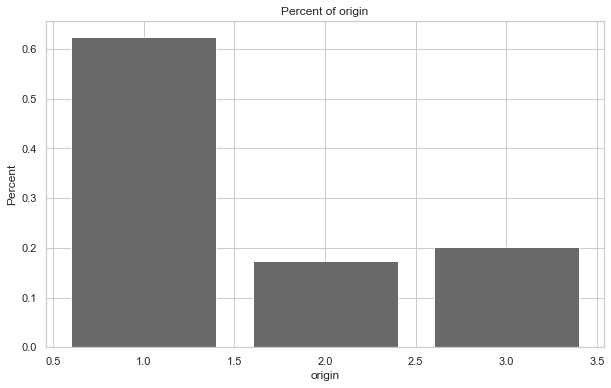

In [21]:
barplot(data, "origin", percent = True)

About 60% of the cars in the data set originate from the united states. Origin will be tough to decide on how to incorporate in our model. Now that we've gone through each of the individual variables, we will begin the pairwise EDA with the MPG target variable.

### 1.2.9 - MPG vs Cylinders <a class="anchor" id="vscyl"></a>
[Contents](#contents)

The number of cylinders a car has generally should correlate with the power it outputs. I'd expect that bigger engines will be less fuel efficient. lets do a quick correlation:

In [22]:
correlation(data, "mpg", "cylinders")

Correlation coefficients:
r   = -0.7776175081260226
rho = -0.8231746391245732


Right of the bat we see a very negatively correlated relationship with Pearson's r. Spearman's rho is even more negative at -0.823 which suggests a high monotonic relationship in the negative direction.

A set of boxplots might be the best way to showcase the data given that cylinders is a discrete numeric variable with only 7 possibilities. We could effectively treat the cylinders variable as a categorical variable.

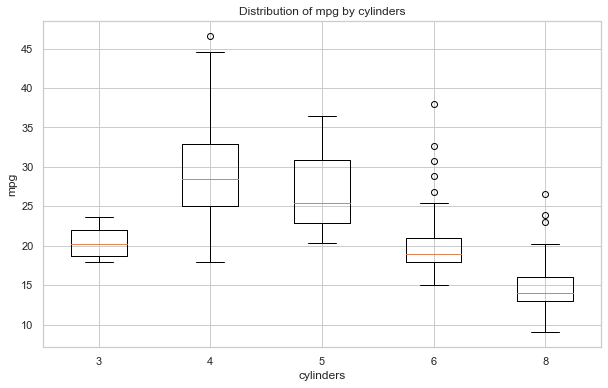

In [23]:
multiboxplot(data, 'mpg', "cylinders")

There does seem to be a decreasing trend in terms of MPG as the number of cylinders increases. The odd one out are the 3 cylinder cars. There probably aren't many points that affect the correlation in the 3 cyclinder category.

In [24]:
data[data["cylinders"] == 3]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
mazda rx2 coupe,19.0,3,70.0,97.0,2330.0,13.5,72,3
maxda rx3,18.0,3,70.0,90.0,2124.0,13.5,73,3
mazda rx-4,21.5,3,80.0,110.0,2720.0,13.5,77,3
mazda rx-7 gs,23.7,3,70.0,100.0,2420.0,12.5,80,3


There are only 4 cars with 3 cylinders. The variable by itself in this category might not be very useful to us given the sparsity of the data point. Perhaps the effect of having 3 cyclinders may be more prounounced (or useful to us at least) when it is reflected in the displacement variable.

### 1.2.10 - MPG vs Displacement <a class="anchor" id="vsdisp"></a>
[Contents](#contents)

From intuition, displacement seems to be one of the more important factors in fuel efficiency. It essentially measures engine size and logically should correlate with the amount of fuel consumption. I'd expect there to be a negative correlation with MPG.

In [25]:
correlation(data, "mpg", "displacement")

Correlation coefficients:
r   = -0.8051269467104578
rho = -0.8552335882841172


Both pearson's and spearman's coefficients indicate strong negative correlation. It will be interesting to see how the data looks on a scatterplot:

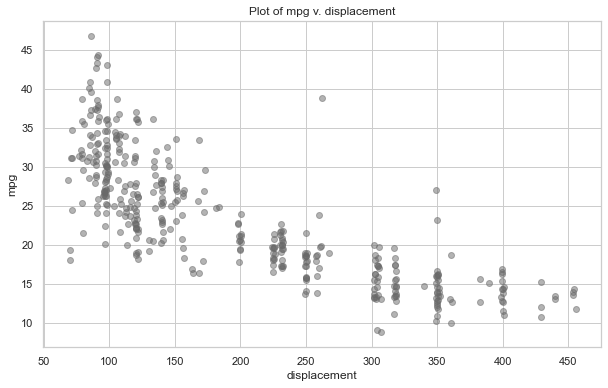

In [26]:
scatter(data, "displacement", "mpg", jitter = 1)

There definitely is a negative correlation. The fuel efficiency of the larger engines with greater displacements seems intuitively reasonable. However, the smaller engines seem to have a much larger range of fuel efficiency. At the lower sizes, we see efficiency vary much more than at higher displacements. Displacements below 200 seem to be affected by this larger range of fuel efficiency. Maybe there's a factor that might help differentiate those fuel effeciencies.

### 1.2.11 - MPG vs Horsepower <a class="anchor" id="vshp"></a>
[Contents](#contents)

As with displacement, I'd expect again, a strong negative correlation with our target variable. The more power an engine has, the more fuel it will likely consume.

In [27]:
correlation(data, "mpg", "horsepower")

Correlation coefficients:
r   = -0.7784267838977761
rho = -0.8536164024453882


As expected, mpg is definitely negatively correlated with horsepower.

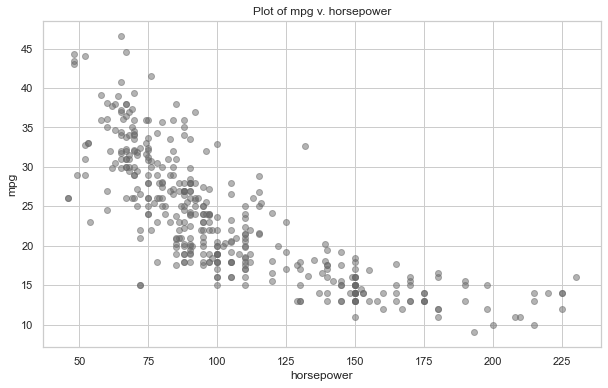

In [28]:
scatter(data, 'horsepower', 'mpg')

This has a very similar distribution to the displacement scatterplot from before. This is most likely because horsepower and displacement are highly correlated themselves. We still have not seen what might be causing the larger range of variablility in the smaller engines.

### 1.2.12 - MPG vs Weight <a class="anchor" id="vswt"></a>
[Contents](#contents)

Weight will again be negatively correlated with MPG.

In [29]:
correlation(data, "mpg", "weight")

Correlation coefficients:
r   = -0.8322442148315755
rho = -0.8755851198739869


So far weight has the highest correlation with MPG.

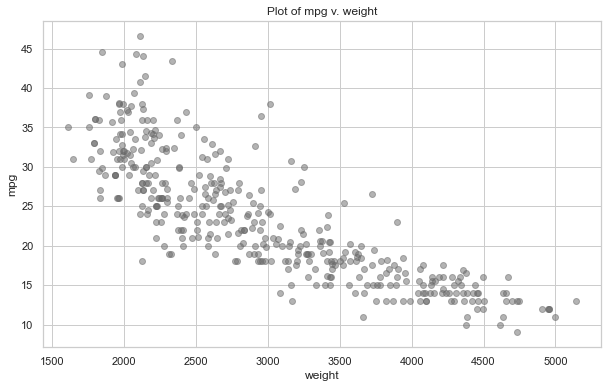

In [30]:
scatter(data, "weight", "mpg")

The scatterplot shows another similar relationship with the other main factors that we have looked at so far. An interesting thing we could try is to use the cylinders variable as a category to overlay on this scatterplot. With the overlay, maybe we can explain some of the variation we are seeing near the lower end of these plots.

<AxesSubplot:xlabel='weight', ylabel='mpg'>

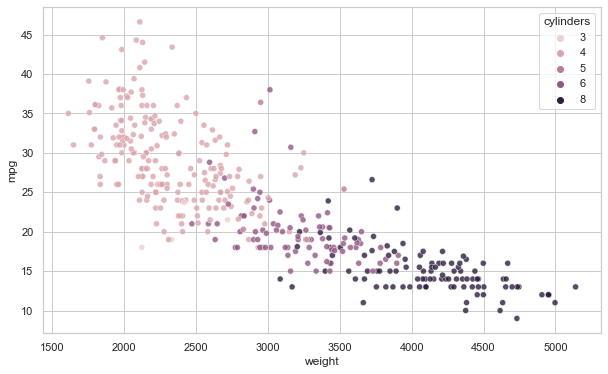

In [31]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
sns.set_palette(sns.color_palette("rocket"))
sns.scatterplot(x = "weight", y = "mpg", data = data, hue = "cylinders", markers = "o", alpha=0.8)

Nothing informative came out of this plot. There's no significant difference in the the number of cylinders relative to the variation we see at the lower end of the weight variable.

### 1.2.13 - MPG vs Accelleration <a class="anchor" id="vsacc"></a>
[Contents](#contents)

Accelleration seems to be another variable associated with the power of the engine. It's tougher to predict how acceleration will affect MPG because a lighter car with the same engine can accelerate faster and still be more fuel effecient then a heavier one that has a similar engine.

In [32]:
correlation(data, "mpg", "acceleration")

Correlation coefficients:
r   = 0.42332853690278727
rho = 0.44153885845636487


There's a medium level of correlation here, with both pearson's r and spearman's rho correlation coefficients at around 0.42 - 0.44 respectively.

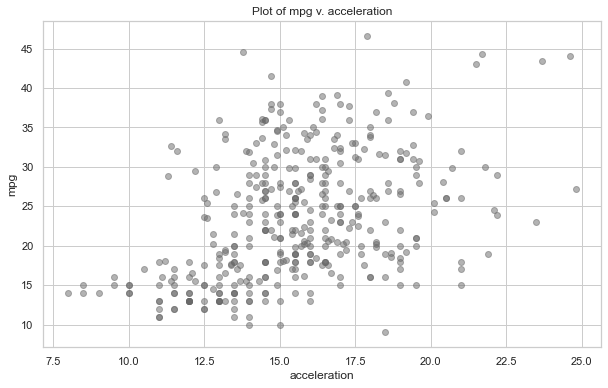

In [33]:
scatter(data, "acceleration", "mpg")

This was what I expected, given that acceleation could be an indicator of a car's weight or a car's engine power. There's no discernable pattern from this plot however. Acceleration seems to have too many confounding variables that affect it which make it more difficult to use as a predictor. To show this we can quickly plot a comparison between acceleration and other factors like weight and engine size. (displacement). We'll revisit this question after the rest of the pairwise analysis.

### 1.2.14 - MPG vs Year <a class="anchor" id="vsyear"></a>
[Contents](#contents)

The correlation I expect to find between MPG and the model year is a slight positive one, hopefully due to more efficient cars being manufactured in later years.

In [34]:
correlation(data, 'mpg','year')

Correlation coefficients:
r   = 0.5805409660907856
rho = 0.5748408744472727


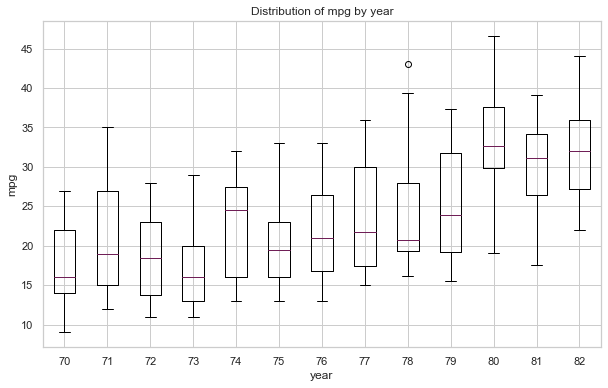

In [35]:
multiboxplot(data, "mpg", "year")

It does in fact look like there is a medium positive relationship between a car model's year and MPG. Maybe this is one of the factors that we were looking for that might explain the variability in MPG at lower engine sizes? There seems to be a steady improvement up to year 79, after which we see a relatively large jump in MPG. Maybe we can specify a categorical variable that indicates whether a car was manufactored after the year 79.

In [36]:
data["post_79"] = np.where(data["year"]>79, 1, 0)

Now we have a categorical variable that describes a car model's year relative to the year 76.

### 1.2.15 - MPG vs Origin <a class="anchor" id="vsorigin"></a>
[Contents](#contents)

Finally we look at the origin variable and how it might affect MPG. Because this is a categorical variable with more than 2 categories, we cannot calculate correlation coefficients so lets move directly to a set of boxplots.

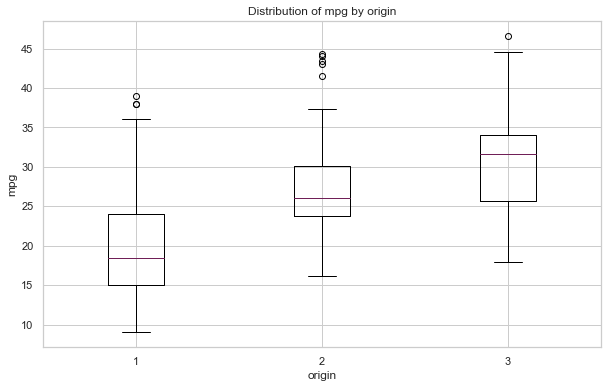

In [37]:
multiboxplot(data, "mpg", "origin")

It looks like the origin of a car might be a decent predictor as we can see a steady increase in MPG based on where the car is produced. Japanese cars seem to have the best MPG rating with American cars having the lowest.

### 1.2.16 - More EDA <a class="anchor" id="meda"></a>
[Contents](#contents)

Previously in our exploration, we looked at acceleration and its influence on MPG. Perhaps the acceleration factor is highly correlated with other engine parameters like displacement and horsepower.

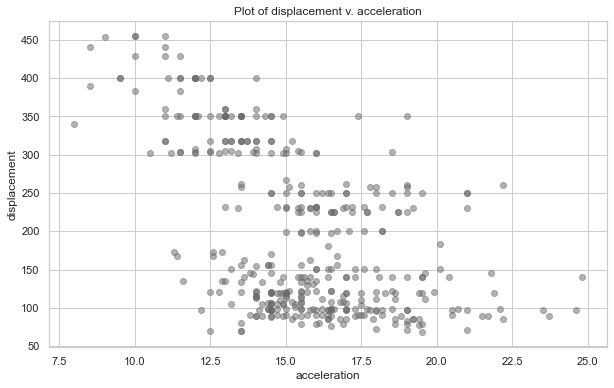

In [38]:
scatter(data, "acceleration", "displacement")

This comparison here is actually quite surprising. I was expecting that cars with higher displacement would have higher acceleration, but here we are seeing the opposite effect. Maybe this is because in our car data set, the engines with higher power (displacement) are all placed in heavier cars.

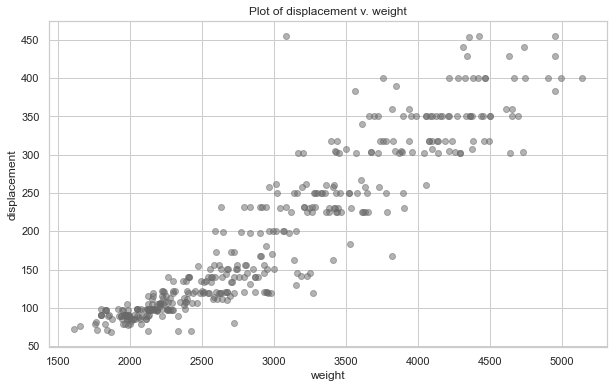

In [39]:
scatter(data, "weight", "displacement")

This scatterplot actually shows a pretty interesting pattern. It helps explain the acceleration vs mpg pattern we saw earlier. All the cars with the larger engines, are heavier. That weight difference might be part of the reason why we're seeing a negative correlation between engine size (displacement) and acceleration.

In [40]:
correlation(data, "displacement", "acceleration")

Correlation coefficients:
r   = -0.5438004967345673
rho = -0.4994033557521728


Here we confirm the negative correlation between displacement and acceleration. We can also look at acceleration and car weight to see how much those are correlated.

In [41]:
correlation(data, "weight", "acceleration")

Correlation coefficients:
r   = -0.4168392020037066
rho = -0.40510866812527574


There seems to be less of a correlation here compared to displacement and acceleration.

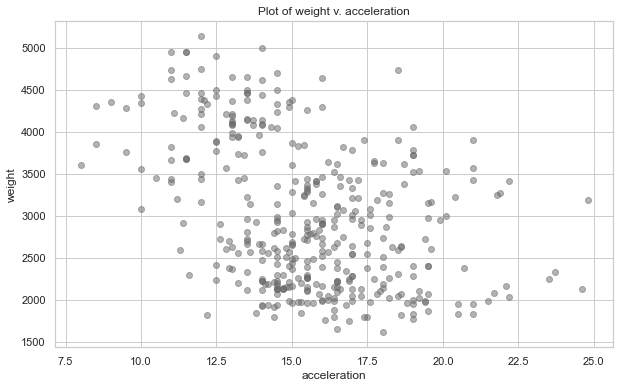

In [42]:
scatter(data, "acceleration", "weight")

This scatterplot is kind of interesting in that we see what looks like a separation of the data. There are a group of larger heavier cars that have lower acceleration and the remaining cars that have lower weight and higher acceleration. It's not super clear but maybe we can highlight the two groups?

<AxesSubplot:xlabel='acceleration', ylabel='weight'>

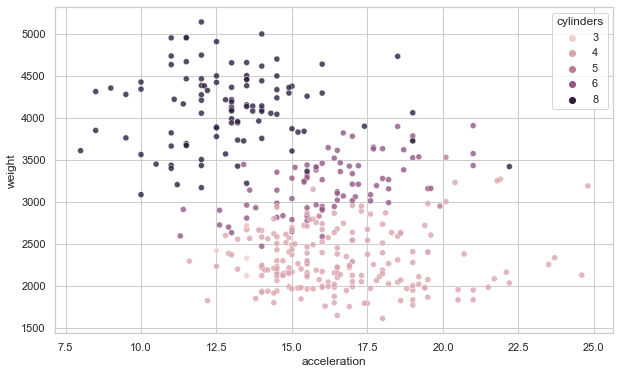

In [43]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["red", "dimgray"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "acceleration", y = "weight", data = data, hue = "cylinders", markers = "o", alpha=0.8)

It seems like the group of cars that have lower acceleration actually have the highest weight AND more cylinders on average. That group of cars might be why the larger engines are associated with lower acceleration. We can the same plot using horsepower on the x axis to see if the pattern is similar.

<AxesSubplot:xlabel='horsepower', ylabel='weight'>

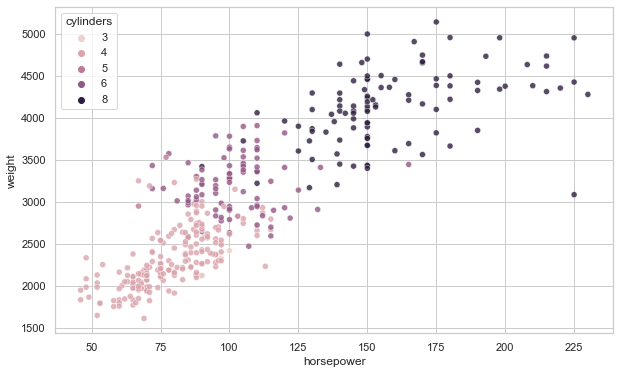

In [44]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["red", "dimgray"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "horsepower", y = "weight", data = data, hue = "cylinders", markers = "o", alpha=0.8)

Again the more power a car has, the heavier it tends to be, offsetting its acceleration. This helps explain why our acceleration distribution is relatively normally distributed. Note that the pattern we see above is likely the same if we used horsepower or displacement as the independent variable:

<AxesSubplot:xlabel='displacement', ylabel='weight'>

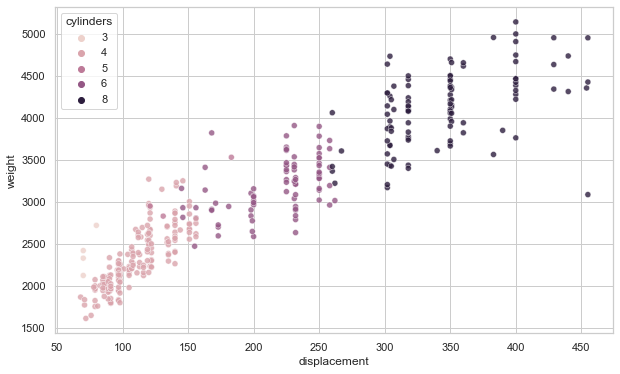

In [45]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["red", "dimgray"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "displacement", y = "weight", data = data, hue = "cylinders", markers = "o", alpha=0.8)

Ignoring some of the jaggedness of the plot, it looks almost identical to the horsepower one. This is because horsepower and displacement are so closely related.

Lets revisit one of the previous pairwise comparisons we made involving MPG.

<AxesSubplot:xlabel='displacement', ylabel='mpg'>

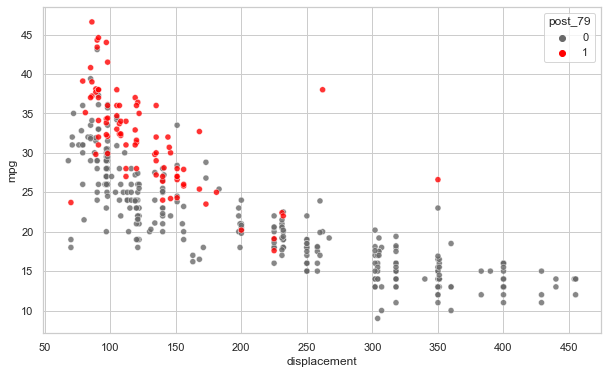

In [46]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["dimgray", "red"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "displacement", y = "mpg", data = data, hue = "post_79", markers = "o", alpha=0.8)

Here we see something very interesting. For cars built after 76, there seems to be an upward shift in mpg. Maybe this pattern is present with other independent variables. Lets try acceleration.

<AxesSubplot:xlabel='acceleration', ylabel='mpg'>

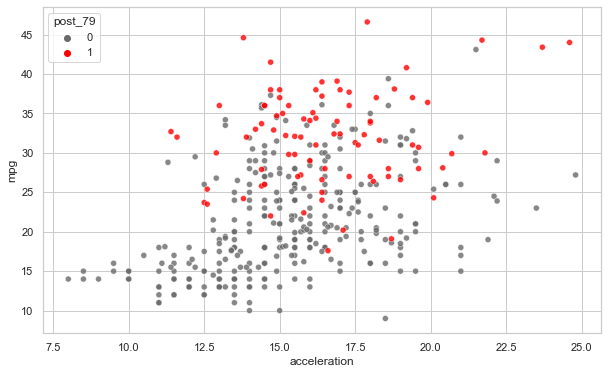

In [47]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["dimgray", "red"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "acceleration", y = "mpg", data = data, hue = "post_79", markers = "o", alpha=0.8)

This is a little bit less interesting, mostly because the previous example was more tangible. Here we do see a slight upward shift MPG relative to acceleration. Let's try horsepower (which should look a lot like displacement).

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

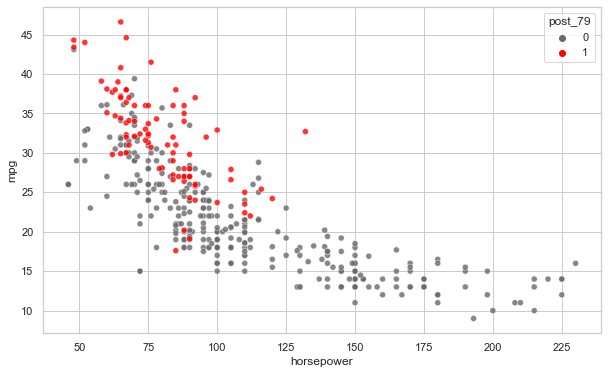

In [48]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["dimgray", "red"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "horsepower", y = "mpg", data = data, hue = "post_79", markers = "o", alpha=0.8)

As expected, it looks a lot like the version with displacement. One more thing that might be interesting to see is if a transformation of the dependent variable can reduce the curve that we're seeing. Lets try a log transformation

In [49]:
data["horsepower_log"] = np.log(data["horsepower"])

<AxesSubplot:xlabel='horsepower_log', ylabel='mpg'>

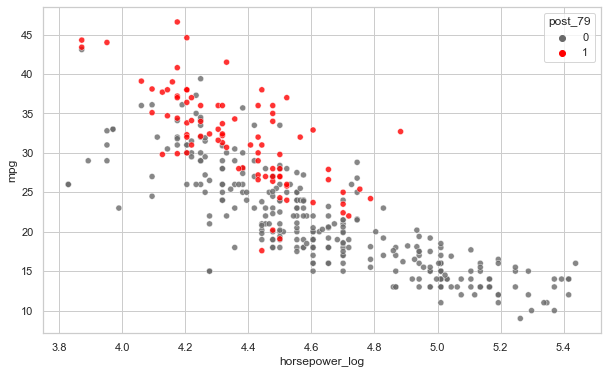

In [50]:
figure = plt.figure(figsize =(10,6))
axes = figure.add_subplot(1,1,1)
colors = ["dimgray", "red"]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x = "horsepower_log", y = "mpg", data = data, hue = "post_79", markers = "o", alpha=0.8)

Using a log transformation seems to eliminate the curve in our plot. However interpretability is important so when we will start with the untransformed data set and analyze residuals to see if any transformations are necessary.

## 1.3 - Build the model <a class="anchor" id="modeling"></a>
[Contents](#contents)

One of the major findings in our EDA is that many of the variables in some way shape or form measure the same thing. As such, our datapoints are subject to multicollinearity. Horsepower, cylinders, and displacement are all correlated. Larger engines have more cylinders, which usually results in higher displacement and horsepower. Incorporating all 3 of these into our model might make it difficult to discern what's more important.

Another thing we need to do is create dummy variables for the origin variable. We'll treat cylinders as a numerical variable.

We begin by creating dummy variables for origin:

In [51]:
data = pd.concat([data, pd.get_dummies(data["origin"])], axis =1)
data = data.rename(columns = {1: "American", 2: "European", 3: "Japanese"})
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,post_79,horsepower_log,American,European,Japanese
name,,,,,,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,4.867534,1,0,0
buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,5.105945,1,0,0
plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,5.010635,1,0,0
amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,5.010635,1,0,0
ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,4.941642,1,0,0


With the dummy variables created we can do a quick correlations calculation to remind us of what we should expect. Note that for our dummy variables we will set the baseline to be American and drop that variable from the model. This means that the $\beta_0$ coefficient should incorporate that in its value.

In [52]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})
correlations(data, "mpg", ["cylinders", "displacement", "horsepower", "weight", "acceleration", "year", "post_79", "European", "Japanese"])

,feature,r,rho
0,cylinders,-0.777618,-0.823175
1,displacement,-0.805127,-0.855234
2,horsepower,-0.778427,-0.853616
3,weight,-0.832244,-0.875585
4,acceleration,0.423329,0.441539
5,year,0.580541,0.574841
6,post_79,0.575757,0.548464
7,European,0.244313,0.253350
8,Japanese,0.451454,0.450745


Here we see the negative relationships between the major features like cylinders, displacement, and horsepower. Meanwhile we have moderatly postivie relationships between acceleration and mpg (which is intersting in its own right but is probably due to higher acceleration being also associated with lighter cars). The year variable on its own seems to have a better correlation than the post_76 categorical transformation that I introduced. We might just go with year as our variable. Finally origin tends to improve mpg if the car is made outside the US.

Lets now analyze the null model (mean model).

In [53]:
data.mpg.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The mean is 23.46 with a standard deviation of 7.81. In this case $\sigma$ is 7.81.
Lets see how much we can improve the model by using linear regression. We start by incorporating all the variables we have except for the post_76 transformation that is redundent relative to the year feature.

In [55]:
model = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + European + Japanese"
result1 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-17.95,-27.13,-6.01
cylinders,$\beta_{1}$,-0.49,-1.02,0.16
displacement,$\beta_{2}$,0.02,0.01,0.04
horsepower,$\beta_{3}$,-0.02,-0.04,0.01
weight,$\beta_{4}$,-0.01,-0.01,-0.00
acceleration,$\beta_{5}$,0.08,-0.24,0.33
year,$\beta_{6}$,0.78,0.69,0.89
European,$\beta_{7}$,2.63,1.43,3.83
Japanese,$\beta_{8}$,2.85,1.82,3.71


Given the number of features, lets check adjusted $R^2$ to control for that and see if we still have a strong correlation

In [64]:
print(models.adjusted_r_squared(result1))

0.8195852827704977


We have an adjusted correlation coefficient of 0.82 which is not bad for our first attempt at building the model. Our error has reduced from 7.81 to 3.31.
* The intercept as usual is not something we should look at too deeply.
* Cylinders is negative but there is a chance that it is positive given the CI.
* Displacement, Horsepower, Weight and Acceleration are all a tossup. The means are close to 0 with low and hi ranges hovering around 0 (less true for displacement as the range is 0.01 to 0.04).
* Year is very strongly positively correlated compared to the rest of the variables. This is actually expected given the EDA analysis performed prior.
* European and Japanese is strongly positive. The ranges for CI are wide but they don't contain 0 so I'm confident in that result.

A question that we could ask is whether or not we are happy enough with our model. Going from a $\sigma$ of 7.81 to 3.31 is already a pretty big improvement. However, there is an interpretability issue. Cylinders, displacement and horsepower all correspond to variables that define the size of the engine. Maybe if we combined these variables somehow into one variable, we can call engine size, we might get coefficients that make more sense. I believe this is a problem of multicollinearity, as we saw in the [More EDA](#meda) section. For reference, lets calculate those correlation coefficients.

In [65]:
def pairwise_correlations(data, variables):
    rs = []
    rhos = []
    xs = []
    for x in list(combinations(variables, 2)):
        xs.append(x)
        r = stats.pearsonr(data[x[0]], data[x[1]])[0]
        rs.append(r)
        rho = stats.spearmanr(data[x[0]], data[x[1]])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})
    

pairwise_correlations(data, ["cylinders", "displacement", "horsepower", "weight"])

,feature,r,rho
0,"(cylinders, displacement)",0.950823,0.913566
1,"(cylinders, horsepower)",0.842983,0.816188
2,"(cylinders, weight)",0.897527,0.875972
3,"(displacement, horsepower)",0.897257,0.876171
4,"(displacement, weight)",0.932994,0.945630
5,"(horsepower, weight)",0.864538,0.878819


displacement, cylinders, weight AND horsepower all have very high correlations, at least above 0.85 for pearson's r. Perhaps theres a way to merge all of these variables into a single variable that captures the power of an engine relative to the weight of the car? Before seeing what we can do we want to make sure that the coefficients we obtain remain interpretable. Lets start by removing these factors from our linear regression. We will also remove and return to acceleration later because for now our model does not tell us how acceleration really impacts mpg given that the CI ranges both below and above 0.

In [66]:
model = "mpg ~ year + European + Japanese"
result2 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-61.26,-72.73,-52.97
year,$\beta_{1}$,1.08,0.96,1.23
European,$\beta_{2}$,7.48,6.03,8.92
Japanese,$\beta_{3}$,8.43,7.21,9.90
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,5.08,4.71,5.43,
$R^2$,0.58,0.51,0.65,


Of course removing many of these factors has negatively impacted our model, but we're now ready to see the immediate impact by adding the transformed variables that we will look at.

First we know from EDA and domain knowledge, that engine displacement is calculated using the number of cylinders. Let's make a variable that reflects this relationship.

Adding cylinders and displacement back into the model we get:

In [67]:
model = "mpg ~ year + European + Japanese + cylinders + displacement"
result3 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-21.09,-31.05,-12.43
year,$\beta_{1}$,0.71,0.59,0.83
European,$\beta_{2}$,1.44,-0.01,2.99
Japanese,$\beta_{3}$,2.75,1.68,3.90
cylinders,$\beta_{4}$,-0.78,-1.56,0.15
displacement,$\beta_{5}$,-0.03,-0.05,-0.02
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.89,3.49,4.20,


thats a large jump from an $R^2$ of 0.58 to 0.76. However we still don't really know how the number cylinders impacts mpg. Given the CI it could be either positive or negative. Lets now try a variable transformation on cylinders and displacement. Displacement is calculated using cylinders. As such we can calculate a new variable, displacement per cylinder, which effectively calculates an engines cylinder volume. Then we keep the cylinders variable in the regression so we effectively have the equivalent of displacement in the model.

In [68]:
data["disp_cyl"] = data["displacement"]/data["cylinders"]

model = "mpg ~ year + European + Japanese + disp_cyl + cylinders"
result4 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-11.72,-22.64,-2.26
year,$\beta_{1}$,0.71,0.59,0.84
European,$\beta_{2}$,0.38,-0.88,1.89
Japanese,$\beta_{3}$,1.45,0.34,2.47
disp_cyl,$\beta_{4}$,-0.32,-0.39,-0.25
cylinders,$\beta_{5}$,-1.60,-1.93,-1.32
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.69,3.24,4.02,


With this transformation of displacement we gain a little bit more power out of our regression then we would have with simply displacement and cylinders.

The coefficient shows that the higher the displacement is relative to the number cylinders, ie, the larger the volume of the engine cylinders, the less fuel efficient it is. This measurement is a very direct calculation of the size of the engine, and reduces the interpretability issue that comes with having the two variables seperately applied in our model.

Now we're ready to look at weight and horsepower.

Lets simply add them into the mix:


In [69]:
model = "mpg ~ year + European + Japanese + disp_cyl + cylinders + weight + horsepower"
result5 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-16.94,-26.73,-8.08
year,$\beta_{1}$,0.76,0.66,0.87
European,$\beta_{2}$,1.85,0.34,3.23
Japanese,$\beta_{3}$,2.15,0.97,3.28
disp_cyl,$\beta_{4}$,-0.03,-0.14,0.07
cylinders,$\beta_{5}$,0.10,-0.46,0.65
weight,$\beta_{6}$,-0.01,-0.01,-0.00
horsepower,$\beta_{7}$,-0.01,-0.03,0.01
,,,,


Adding weight and horsepower increased our $R^2$ to 0.82 and reduced our $\sigma$ to 3.34. This is pretty good but theres a problem. Some of the feature coefficients are now no longer as interpretable. The CI for displacement per cylinder and cylinders now includes 0 and could be either positive or negative. We do know however that weight, horsepower, cylinders, and displacement are all highly correlated. Interactions terms here might help. Lets start with horsepower and weight.

In [70]:
model = "mpg ~ year + European + Japanese + disp_cyl + cylinders + weight + horsepower + weight:horsepower"
result6 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-0.97,-8.08,9.26
year,$\beta_{1}$,0.79,0.70,0.87
European,$\beta_{2}$,1.69,0.55,2.70
Japanese,$\beta_{3}$,1.68,0.57,2.35
disp_cyl,$\beta_{4}$,0.04,-0.06,0.13
cylinders,$\beta_{5}$,0.31,-0.11,0.81
weight,$\beta_{6}$,-0.01,-0.01,-0.01
horsepower,$\beta_{7}$,-0.22,-0.28,-0.18
weight:horsepower,$\beta_{8}$,0.00,0.00,0.00


This really improved our $R^2$. However, note that the interaction term is 0.00. This is actually due to a scaling issue. weight is in the 1000s of points, while horsepower is only in the 100s. In fact this is also true for weight as a term in general. Lets change the scale from unit lbs to unit 1000 lbs and then try the regression again to see how the coefficients change. This should not change the $R^2$.

In [71]:
data["weight_ks"] = data["weight"] / 1000

model = "mpg ~ year + European + Japanese + disp_cyl + cylinders + weight_ks + horsepower + weight_ks:horsepower"
result7 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-0.97,-10.15,6.22
year,$\beta_{1}$,0.79,0.71,0.90
European,$\beta_{2}$,1.69,0.40,2.85
Japanese,$\beta_{3}$,1.68,0.83,2.79
disp_cyl,$\beta_{4}$,0.04,-0.05,0.14
cylinders,$\beta_{5}$,0.31,-0.14,0.73
weight_ks,$\beta_{6}$,-11.71,-13.19,-10.06
horsepower,$\beta_{7}$,-0.22,-0.28,-0.17
weight_ks:horsepower,$\beta_{8}$,0.06,0.04,0.07


We can now try adding an interaction variable between weight_ks and cylinder volume:

In [72]:
model = "mpg ~ year + European + Japanese + disp_cyl + cylinders + weight_ks + horsepower + weight_ks:horsepower + weight_ks:disp_cyl"
result8 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.92,-7.96,10.04
year,$\beta_{1}$,0.79,0.70,0.87
European,$\beta_{2}$,1.57,0.08,2.91
Japanese,$\beta_{3}$,1.47,0.26,2.46
disp_cyl,$\beta_{4}$,-0.15,-0.38,0.18
cylinders,$\beta_{5}$,0.27,-0.15,0.72
weight_ks,$\beta_{6}$,-12.44,-13.86,-11.03
horsepower,$\beta_{7}$,-0.18,-0.26,-0.11
weight_ks:horsepower,$\beta_{8}$,0.04,0.03,0.07


It doesn't look like adding that last interaction term made a difference in our model. We'll remove it. However there is one last thing that our EDA suggested we could try. Based on our exploration of the year variable, we know that mpg efficiency increased after the year 79 from a multiboxplot. This suggests a good variable to incorporate: a categorical variable describing the make of car either before or after the year 79.

In [73]:
model = "mpg ~ year + European + Japanese + disp_cyl + cylinders + weight_ks + horsepower + weight_ks:horsepower + post_79"
result9 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,15.14,6.20,24.23
year,$\beta_{1}$,0.55,0.43,0.69
European,$\beta_{2}$,1.64,0.57,2.81
Japanese,$\beta_{3}$,1.38,0.49,2.29
disp_cyl,$\beta_{4}$,0.02,-0.06,0.10
cylinders,$\beta_{5}$,0.40,0.02,0.79
weight_ks,$\beta_{6}$,-11.04,-12.92,-9.39
horsepower,$\beta_{7}$,-0.21,-0.27,-0.17
weight_ks:horsepower,$\beta_{8}$,0.05,0.04,0.06


With that addition to the model, our $R^2$ jumped a point and $\sigma$ dropped 0.09. Lets check if the number of features is a reason:

In [74]:
models.adjusted_r_squared(result9)

0.8695819042740478

Overall this looks fairly promissing.
Lets check residuals to be sure.

In [75]:
def plot_residuals(data, result, variables):
    figure = plt.figure(figsize=(20,15))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()

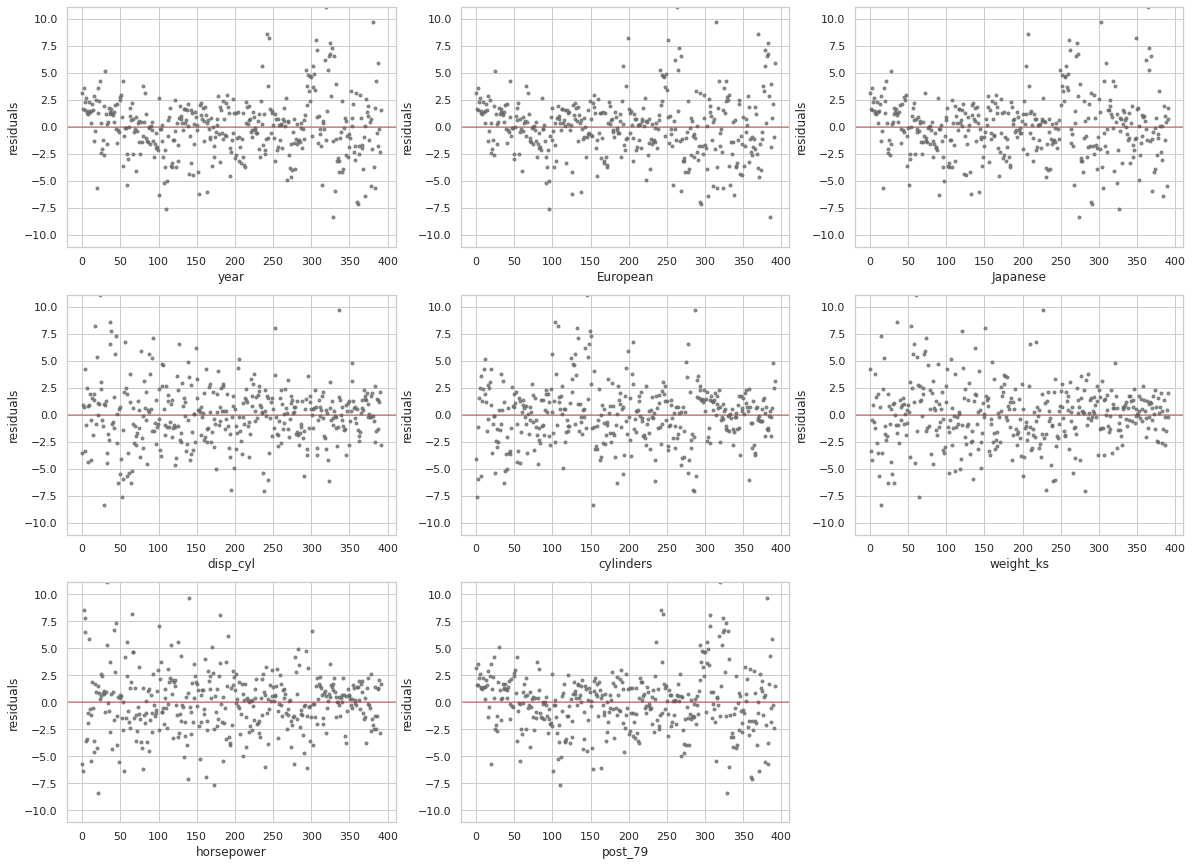

In [76]:
plot_residuals(data, result9, ["year", "European", "Japanese", "disp_cyl", "cylinders", "weight_ks", "horsepower", "post_79"])

There seems to be a slight skew in the variations near the higher end of the residuals. For disp_cyl for example, the range gets tighter. This is true for weights and for horsepower as well. Perhaps a log transform of the target variable will help. Remember that the target variable mpg is not normally distributed and this may help improve our model.

In [77]:
data["log_mpg"] = np.log(data["mpg"])
model = "log_mpg ~ year + European + Japanese + disp_cyl + cylinders + weight_ks + horsepower + weight_ks:horsepower + post_79"
result10 = models.bootstrap_linear_regression(model, data = data)
models.describe_bootstrap_lr(result10)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2.42,2.01,2.78
year,$\beta_{1}$,0.02,0.02,0.03
European,$\beta_{2}$,0.06,0.03,0.11
Japanese,$\beta_{3}$,0.05,0.01,0.09
disp_cyl,$\beta_{4}$,0.00,-0.00,0.01
cylinders,$\beta_{5}$,0.00,-0.02,0.02
weight_ks,$\beta_{6}$,-0.38,-0.43,-0.30
horsepower,$\beta_{7}$,-0.01,-0.01,-0.00
weight_ks:horsepower,$\beta_{8}$,0.00,0.00,0.00


We gained 2 points in $R^2$ which is decent. Lets look at the residuals:

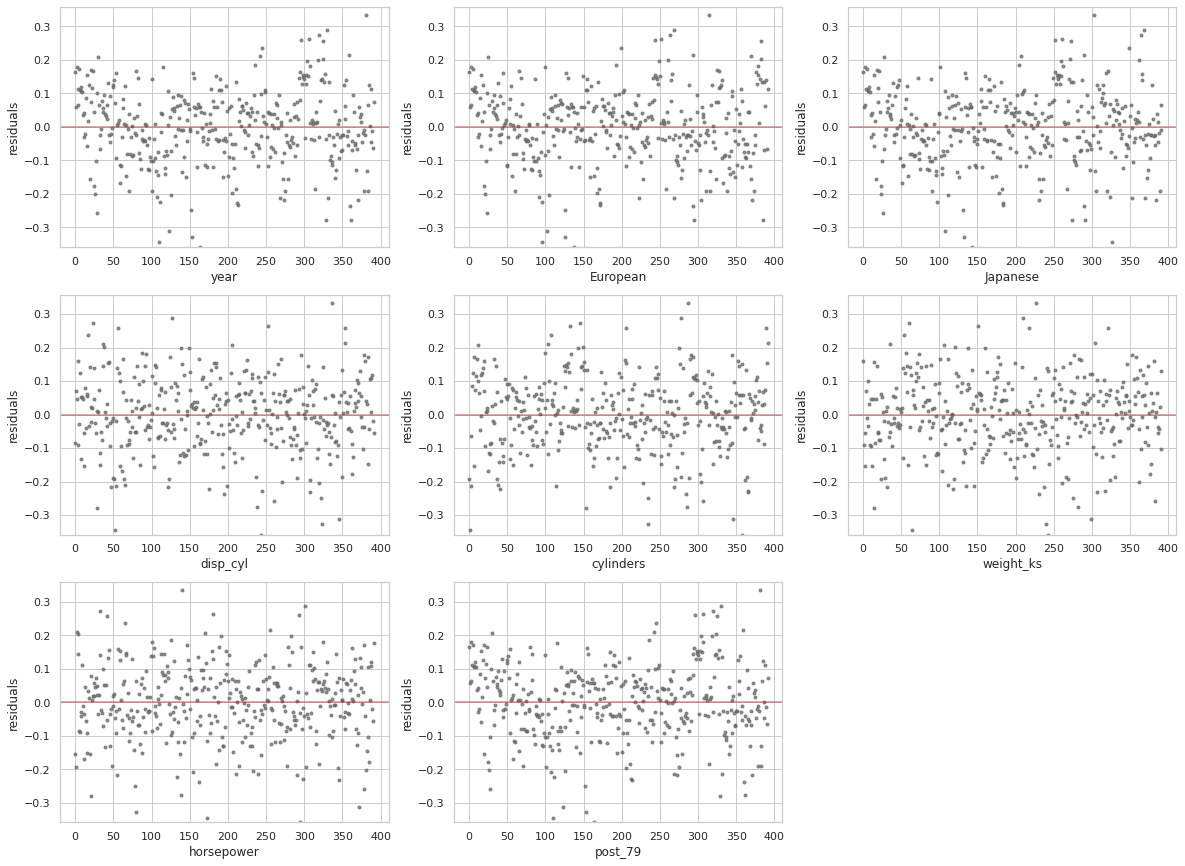

In [78]:
plot_residuals(data, result10, ["year", "European", "Japanese", "disp_cyl", "cylinders", "weight_ks", "horsepower", "post_79"])

The residuals look great. There are no apparent patterns and it seems like we got a pretty strong model with an $R^2$ of 0.89. However, interpretation is very important. We don't gain much from applying this log transformation. Even though the residuals look better, its not a make or break improvement. We'll stick to the non transformed model moving forward.

## 1.4 - Describe the final model <a class="anchor" id="describe"></a>
[Contents](#contents)

The final model is the following: 

In [79]:
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,15.14,6.20,24.23
year,$\beta_{1}$,0.55,0.43,0.69
European,$\beta_{2}$,1.64,0.57,2.81
Japanese,$\beta_{3}$,1.38,0.49,2.29
disp_cyl,$\beta_{4}$,0.02,-0.06,0.10
cylinders,$\beta_{5}$,0.40,0.02,0.79
weight_ks,$\beta_{6}$,-11.04,-12.92,-9.39
horsepower,$\beta_{7}$,-0.21,-0.27,-0.17
weight_ks:horsepower,$\beta_{8}$,0.05,0.04,0.06


Our model explains about 87% of the variance seen in the cars data set. Our $\sigma$ is 2.81. Compared to a  standard deviation of 7.8 using the mean null model and an $R^2$ of 0.82 and a $\sigma$ of 3.31 for standard all in model, this is a pretty good overall improvement. Interpretability is more important in this scenario so opting out of the log transformation--which does improve variation explanation--makes sense.

A car's weight is a strong predictor of mpg efficiency, as a 1 thousand pound increase is associated with an 11 point decrease in mpg. The year of a car between 70 and 82 is actually fairly informative as well, especially when a car was manufactured after the year 79. Every point increase in horsepower is associated with a 0.21 point decrease in MPG. The number of cylinders actually flipped in the analysis from increasing mpg to decreasing it, but that is because we are controlling for engine size.

The origin of the car also has power in adjusting mpg. It seems that from the baseline american car, having a european or japanese manufacturing origin improves mpg which was also expected. The only factor that is not conclusive is the displacement per cylinder factor, given that it ranges between -.08 and 0.1. 

The model as constructed is as follows:
$mpg = 15.14 + 0.55 * year+1.64 * European + 1.39 * Japanese + 0.02 * Displacement Per Cylinder + 0.4 * cylinders -11.04 * 1klbs - 0.21 * horsepower + 0.05 * 1klbs * horsepower + 2.97*post79 $

## 1.5 - Use the model <a class="anchor" id="use"></a>
[contents](#contents)

Let's assume that we built the model for prediction. Let's say we wanted to predict the mpg of a sports car with an 8 cylinder engine built in 1975. Enter the 1975 Dino 208 GT4. It has a weight of 2601 lbs, a v8 engine displacement of 121.5 cubic inches that could generate 167 horsepower.

Lets see if we can accurately predict the mpg.

In [80]:
ferrari = [1.0, 75, 1, 0, 121.5/8, 8, 2.601, 167, 167*2.601, 1]

In [81]:
prediction = result9["model"].predict([ferrari])
prediction

array([[22.76064169]])

According to the true mpg as measured by https://www.encycarpedia.com/us/ferrari/75-dino-208-gt4-coupe, we are off by quite a bit. I believe this might be due to overfitting our model.

In [82]:
prediction[0][0] - 15.1

7.660641688907555

The error of our model was 7.66 in this particular example. However, mpg efficiency was trained on a dataset that did not include more powerful engines in cars with lower weights.

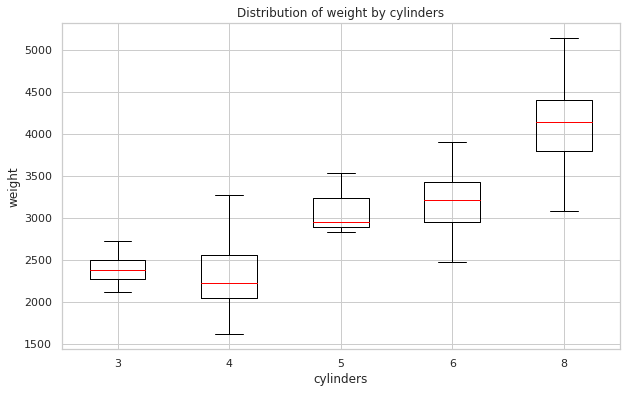

In [83]:
multiboxplot(data, "weight", "cylinders")

The car we tried to predict has an 8 cylinder engine with a body weight typical of cars with 4 cylinder engines. Let's try another car - the bmw 316 1975. More of a consumer level car this one might be more typical of our dataset.

In [84]:
model

'log_mpg ~ year + European + Japanese + disp_cyl + cylinders + weight_ks + horsepower + weight_ks:horsepower + post_79'

In [85]:
bmw = [1, 75, 1, 0, 96.4/4, 4, 2.249, 89, 89*2.249, 0]
prediction = result9["model"].predict([bmw])[0][0]

In [86]:
prediction

26.696529798119013

The fuel consumption provided by https://www.automobile-catalog.com/car/1975/30410/bmw_316.html suggests that our model is pretty good. The 316 is rated at 24 mpg and we prediced 26.69. 

In [87]:
prediction - 24

2.6965297981190126

We overestimated by 2.7 which seems to be just about the expected $\sigma$ from our regression.
What's important to note from this analysis is that the linear model is often only as good as the data you provide it. It was not very good at predicting mpg for a sports car that had a much more powerful engine relative to the weight of the car. This is most likely because the model was fit to data that simply didn't have data on cars that had lower weights and huge 8 cylinder engines.